In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle

import dask
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dask import dataframe as dd
from dask.distributed import Client
from dask_jobqueue import SLURMCluster

import ipas.collection_no_db.m_D_relationship as collect

In [9]:
def start_client(num_workers):
    """start dask client for parallelization"""
    cluster = SLURMCluster(
        queue="kratos",
        walltime="04-23:00:00",
        cores=1,
        memory="10000MiB",  # 1 GiB = 1,024 MiB
        processes=1,
    )

    # cluster.adapt(minimum=3, maximum=20)
    cluster.scale(num_workers)
    client = Client(cluster)
    print("dashboard link: ", cluster.dashboard_link)
    return client

In [3]:
def write_file(filename, agg_as, agg_bs, agg_cs, Aps, Acs, Vps, Ves, Dmaxs):
    """write results to file"""
    results = {
        "agg_as": agg_as,
        "agg_bs": agg_bs,
        "agg_cs": agg_cs,
        "Aps": Aps,
        "Acs": Acs,
        "Vps": Vps,
        "Ves": Ves,
        "Dmaxs": Dmaxs,
    }
    print("saving results to ", filename)
    filehandler = open(filename, "wb")
    pickle.dump(results, filehandler)
    filehandler.close()
    print("done writing!")

In [4]:
def compute(
    phioarr,
    reqarr,
    nclusters,
    ncrystals,
    rand_orient,
    use_dask=False,
    num_workers=2,
    plot=False,
):
    agg_as = np.empty((len(phioarr), len(reqarr), nclusters, ncrystals - 1))
    agg_bs = np.empty((len(phioarr), len(reqarr), nclusters, ncrystals - 1))
    agg_cs = np.empty((len(phioarr), len(reqarr), nclusters, ncrystals - 1))
    Aps = np.empty((len(phioarr), len(reqarr), nclusters, ncrystals - 1))
    Acs = np.empty((len(phioarr), len(reqarr), nclusters, ncrystals - 1))
    Vps = np.empty((len(phioarr), len(reqarr), nclusters, ncrystals - 1))
    Ves = np.empty((len(phioarr), len(reqarr), nclusters, ncrystals - 1))
    Dmaxs = np.empty((len(phioarr), len(reqarr), nclusters, ncrystals - 1))

    output = np.empty((len(phioarr), len(reqarr), nclusters), dtype=object)
    for phi in range(len(phioarr)):
        for r in range(len(reqarr)):
            for n in range(nclusters):
                if use_dask:
                    output[phi, r, n] = dask.delayed(collect.collect_clusters_iceagg)(
                        phioarr[phi], reqarr[r], ncrystals, rand_orient, plot=plot
                    )
                else:
                    (
                        agg_as[phi, r, n],
                        agg_bs[phi, r, n],
                        agg_cs[phi, r, n],
                        Aps[phi, r, n],
                        Acs[phi, r, n],
                        Vps[phi, r, n],
                        Ves[phi, r, n],
                        Dmaxs[phi, r, n],
                    ) = collect.collect_clusters_iceagg(
                        phioarr[phi], reqarr[r], ncrystals, rand_orient, plot=plot
                    )
    if use_dask:
        # start dask client
        print('num workers', num_workers)
        client = start_client(num_workers)
        gather = client.compute([*output.tolist()])
        gather = client.gather(gather)
        gather = np.array(gather)
        agg_as = gather[:, :, :, 0, :]  # phi, r, n, variable position, nm
        agg_bs = gather[:, :, :, 1, :]
        agg_cs = gather[:, :, :, 2, :]
        Aps = gather[:, :, :, 3, :]
        Acs = gather[:, :, :, 4, :]
        Vps = gather[:, :, :, 5, :]
        Ves = gather[:, :, :, 6, :]
        Dmaxs = gather[:, :, :, 7, :]

    return agg_as, agg_bs, agg_cs, Aps, Acs, Vps, Ves, Dmaxs

In [9]:
def main():
    # monomer aspect ratios (all the same in agg)
    #phioarr=np.logspace(-2, 2, num=20, dtype=None)#just columns (0,2); plates (-2,0)
    phioarr = [50.0]
    # monomer radii 
    #reqarr = [1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100,200,300,400,500,600,700,800,900,1000]
    reqarr = [10, 100, 1000]  # microns 
    # how many aggregates to produce
    nclusters = 300
    # number of monomers per aggregate
    ncrystals = 100
    # monomer orientation - random (True) or flat (False)
    rand_orient = True

    # save aggregate attributes to pickled file
    save = False
    #savename (relative path)
    if save:
        filename = '../../instance_files/mD_vT_vars'
        
    # parallelize IPAS using dask
    use_dask = False
    if use_dask:
        num_workers = 10
        agg_as, agg_bs, agg_cs, Aps, Acs, Vps, Ves, Dmaxs = compute(phioarr, reqarr, nclusters, ncrystals,
                                                             rand_orient, use_dask=use_dask,
                                                             num_workers=num_workers)
    else:
        # plot the aggregate?
        plot = True
        agg_as, agg_bs, agg_cs, Aps, Acs, Vps, Ves, Dmaxs = compute(phioarr, reqarr, nclusters,
                                                             ncrystals, rand_orient, plot=plot)

    if save:
        write_file(filename, agg_as, agg_bs, agg_cs, Aps, Acs, Vps, Ves, Dmaxs)
    print('DONE!')

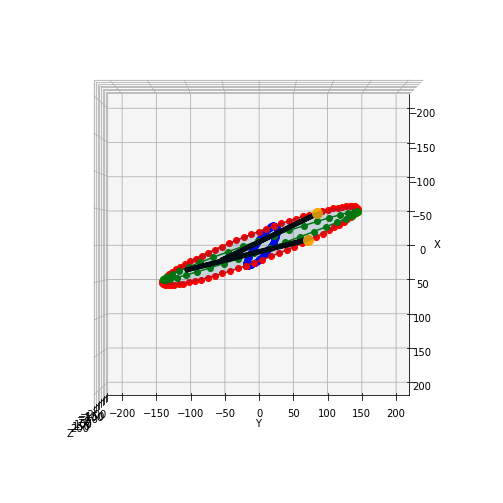

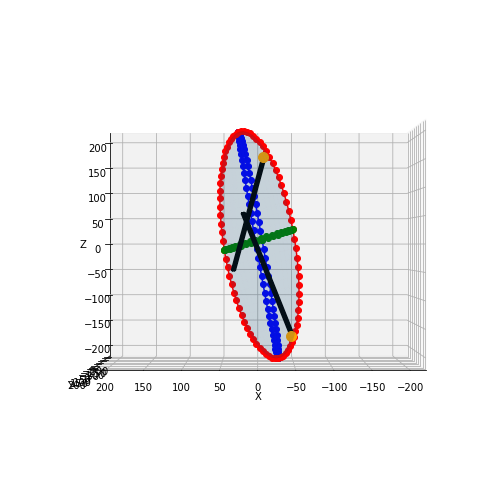

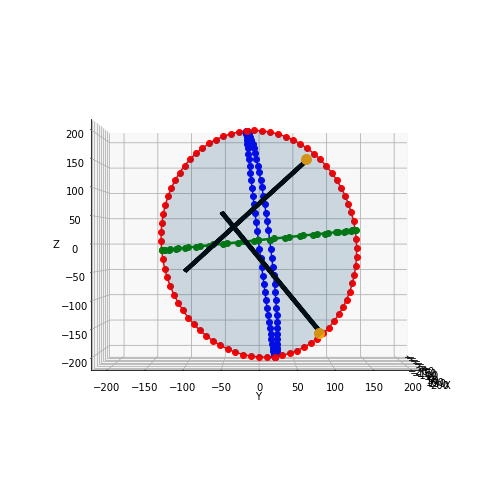

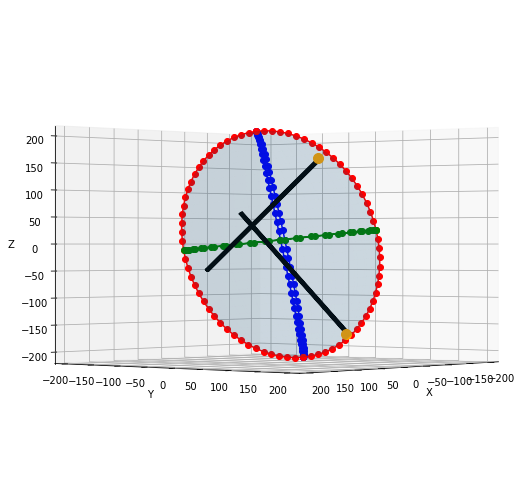

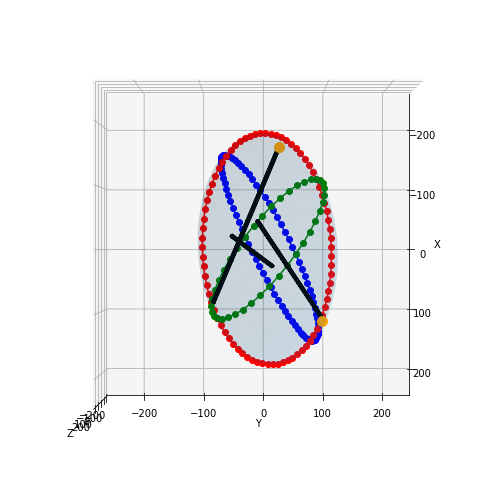

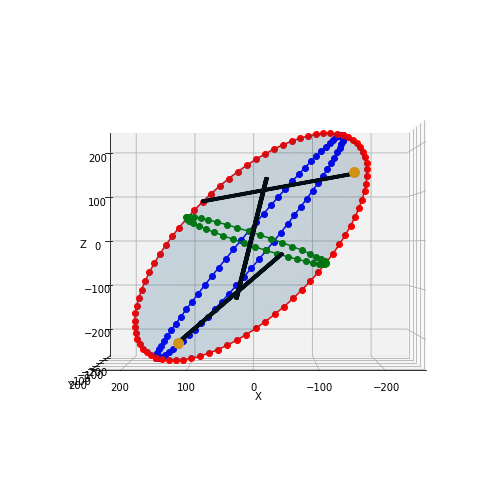

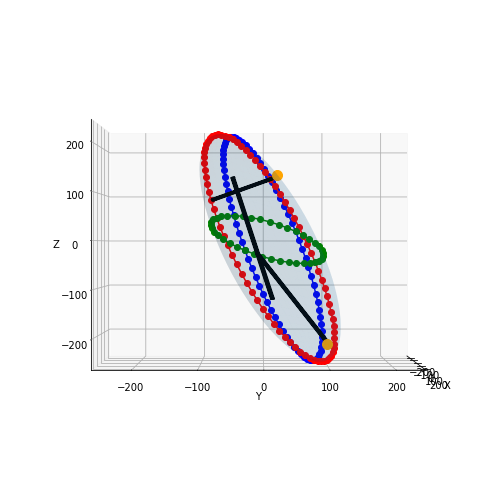

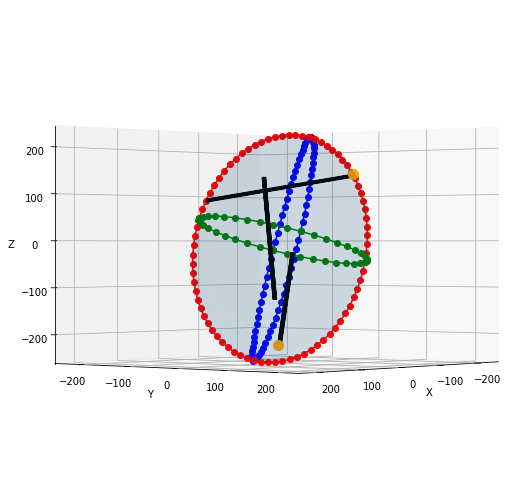

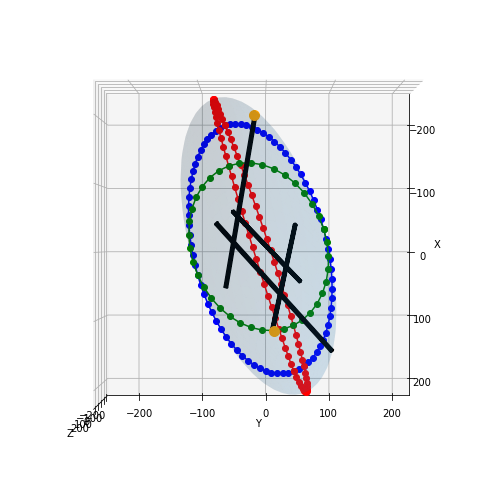

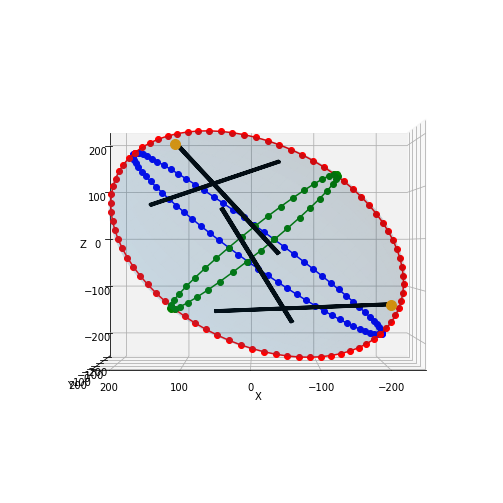

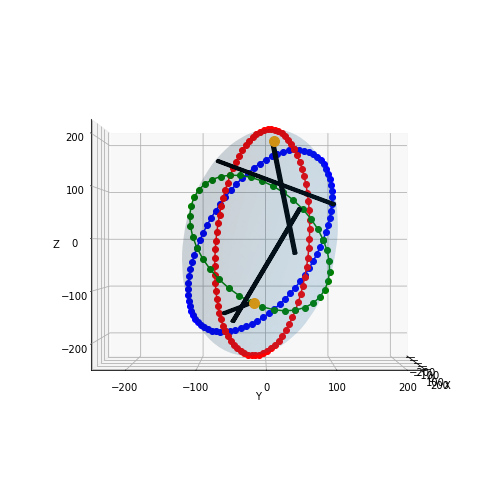

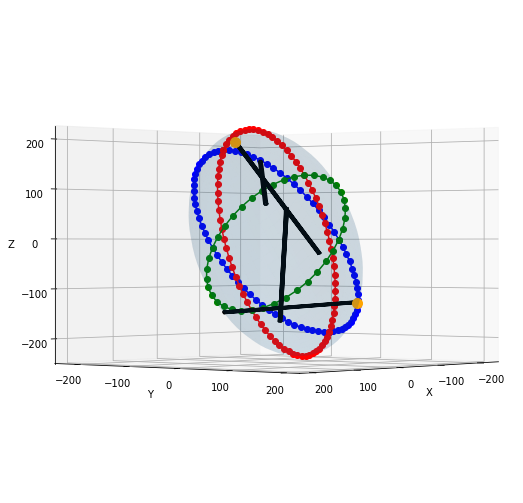

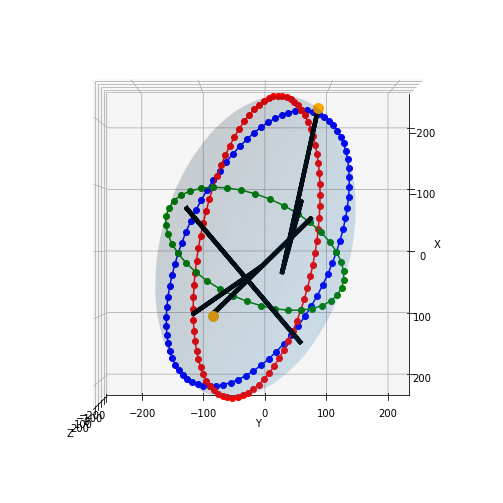

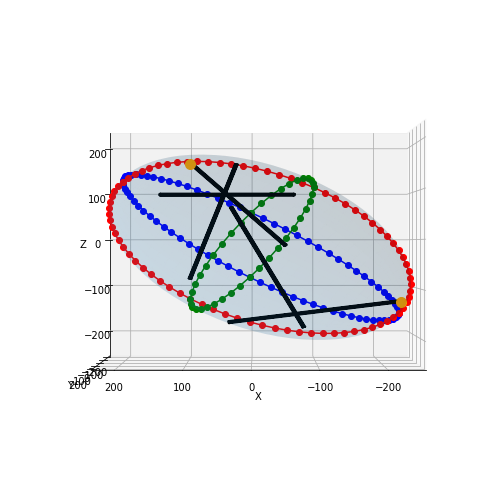

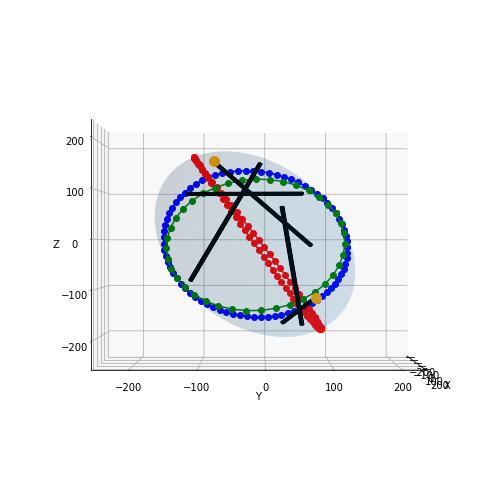

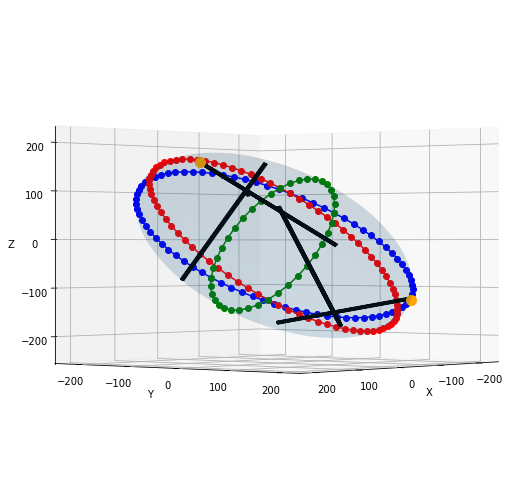

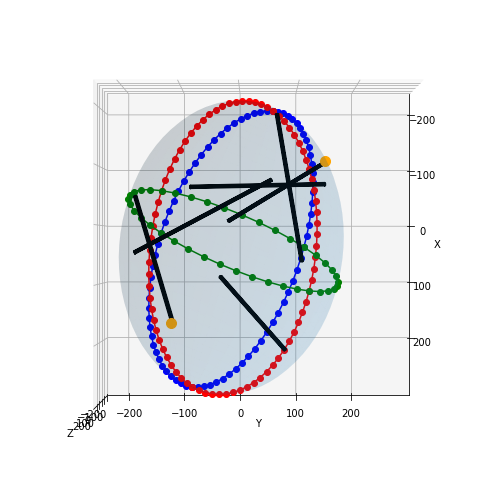

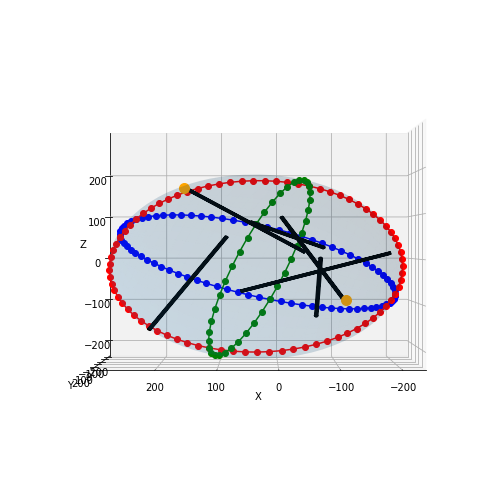

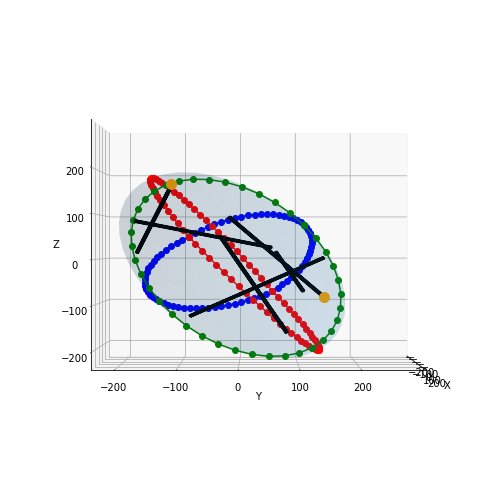

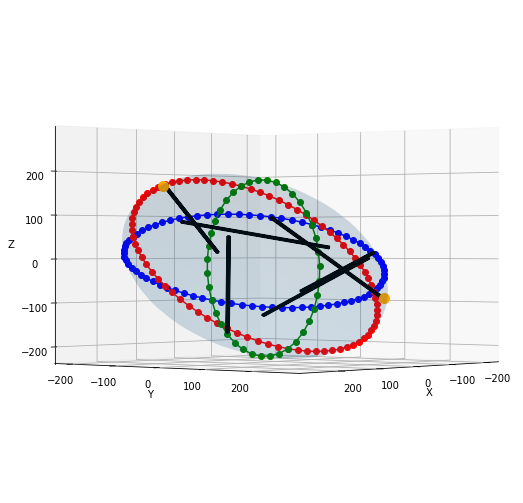

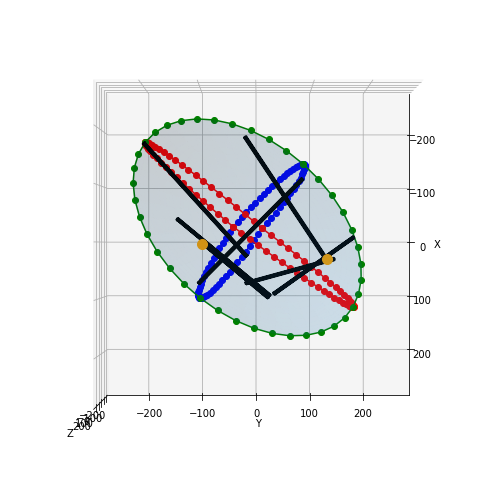

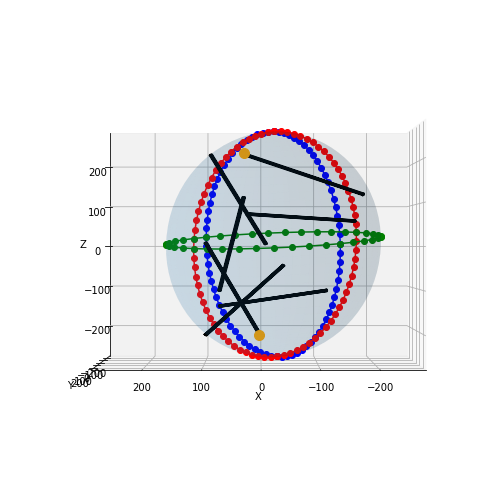

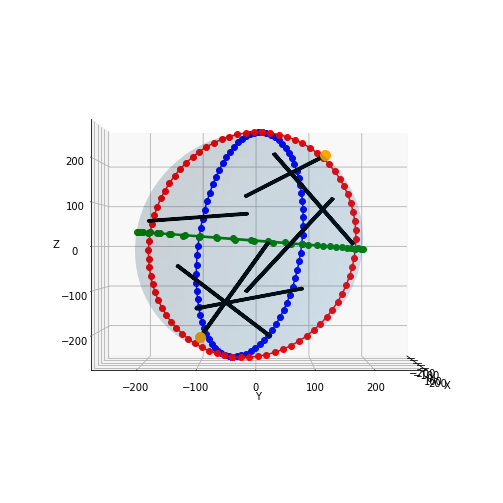

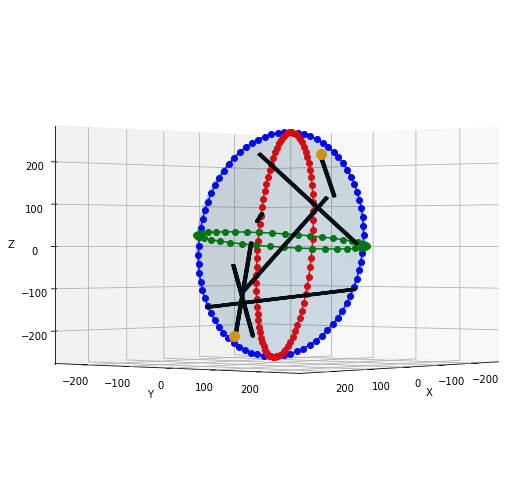

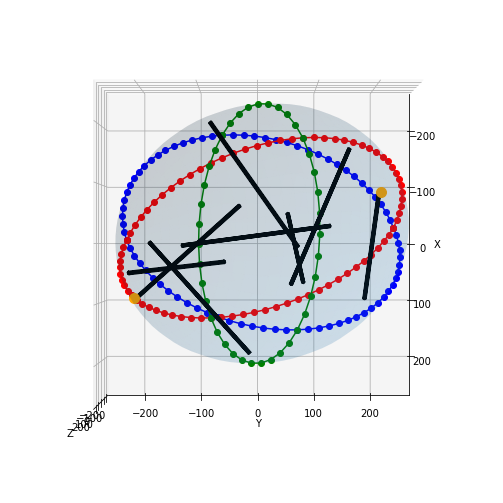

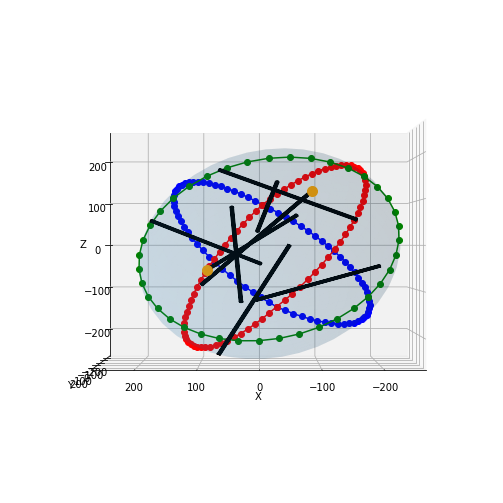

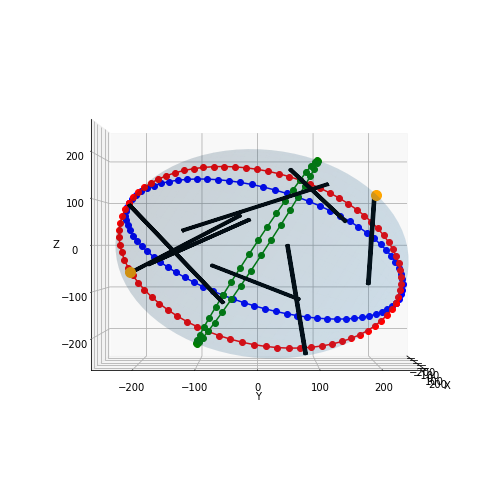

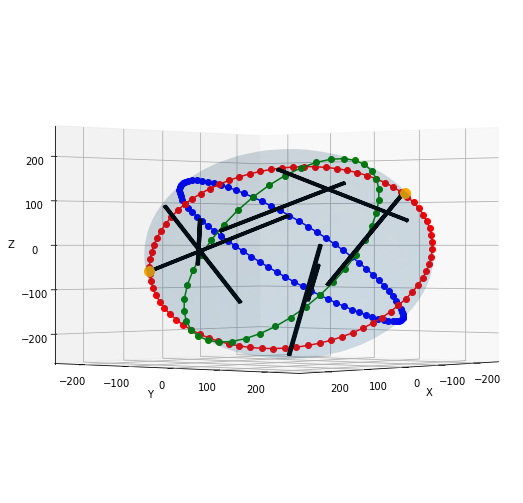

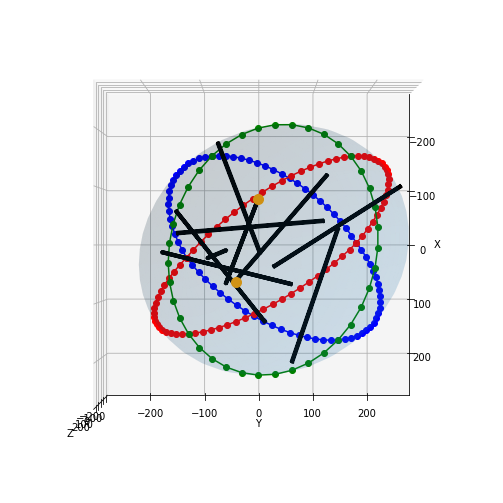

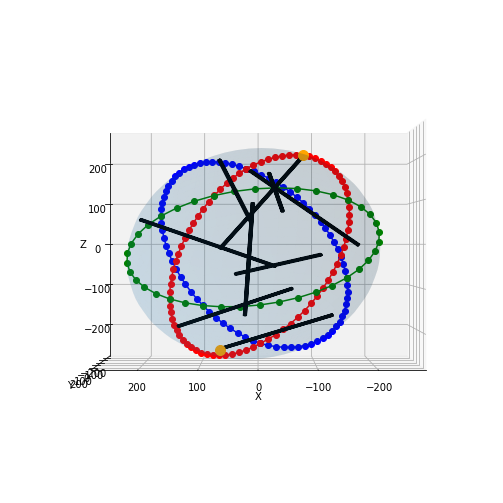

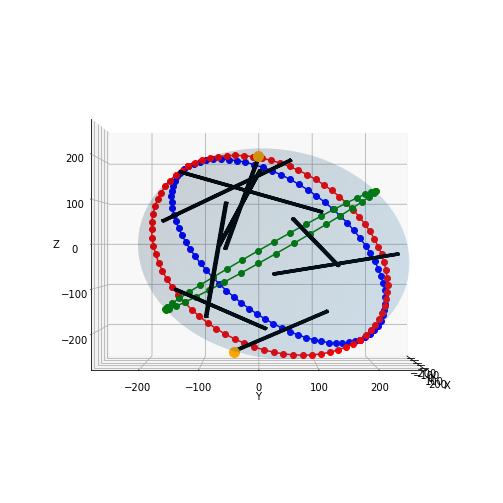

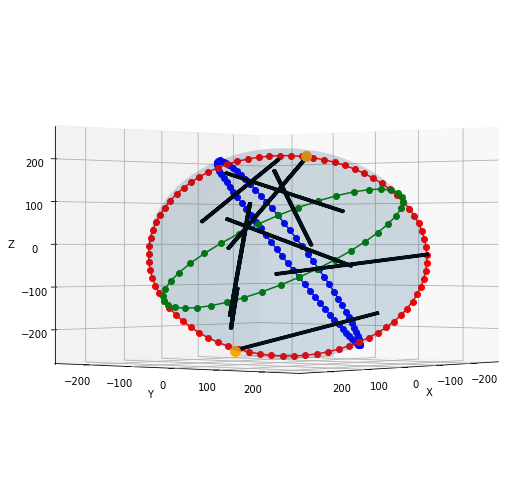

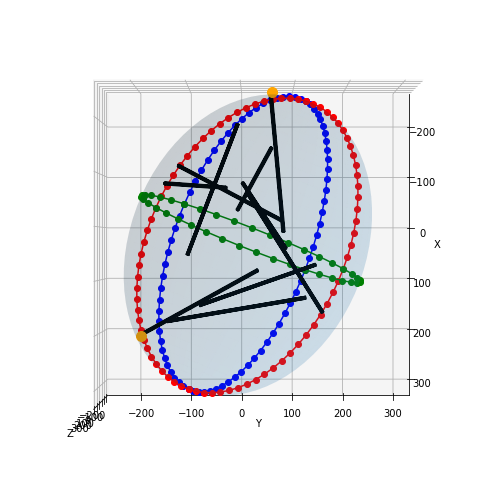

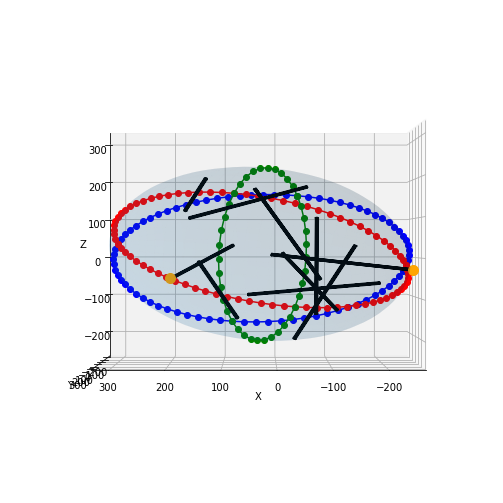

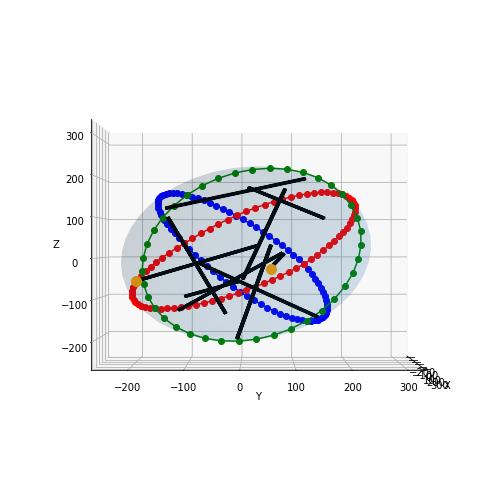

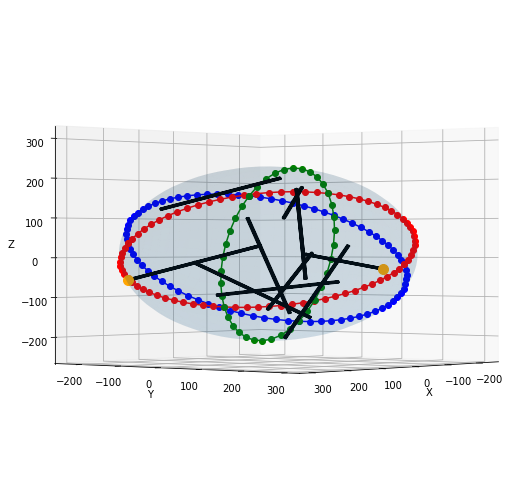

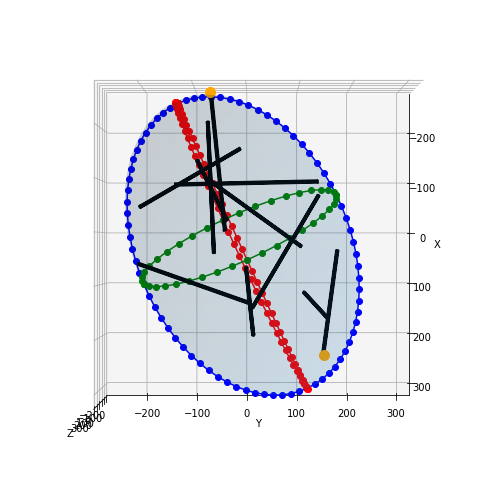

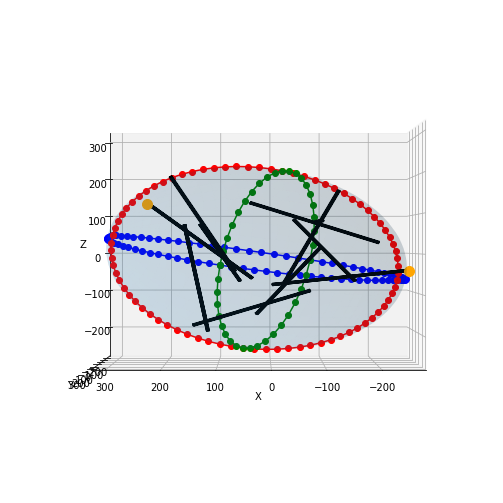

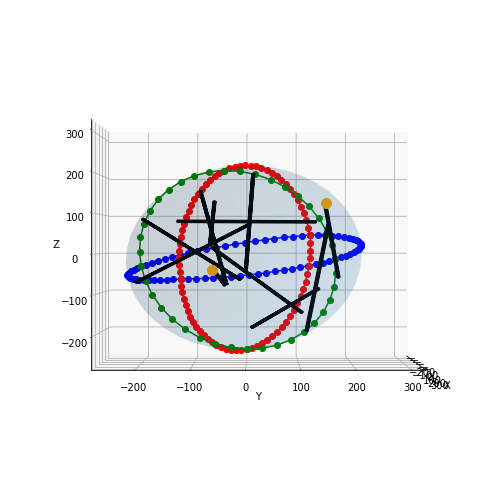

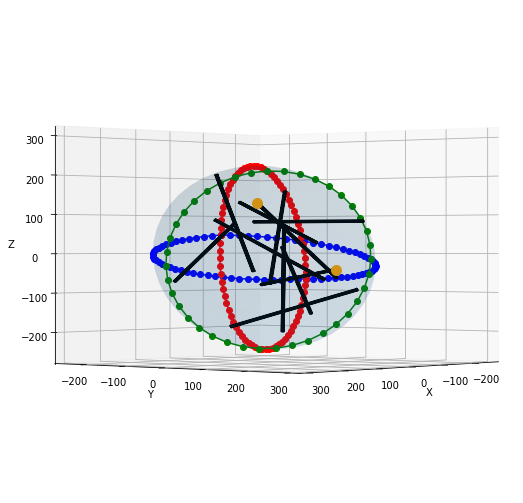

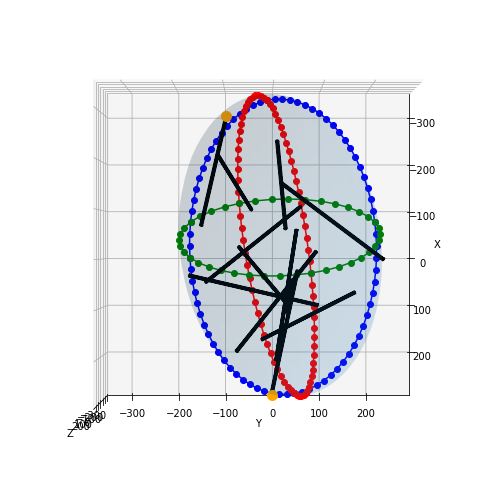

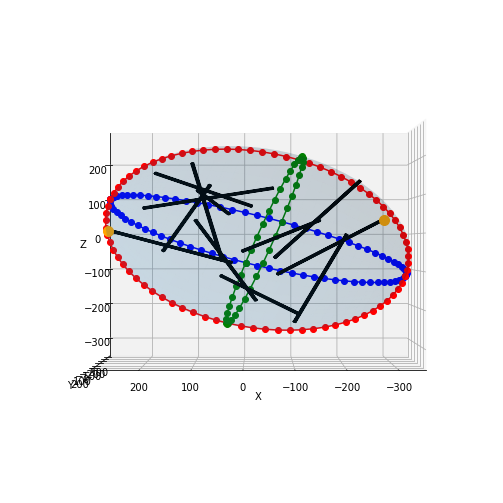

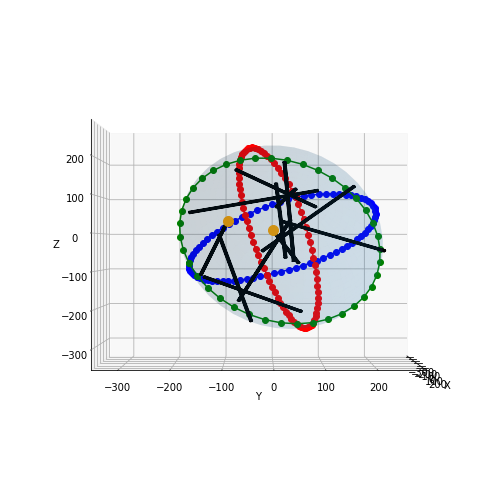

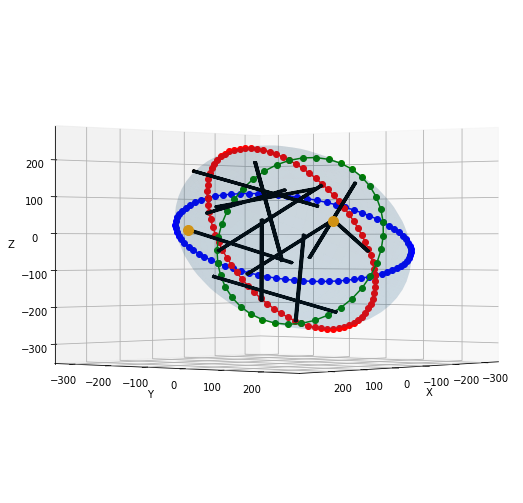

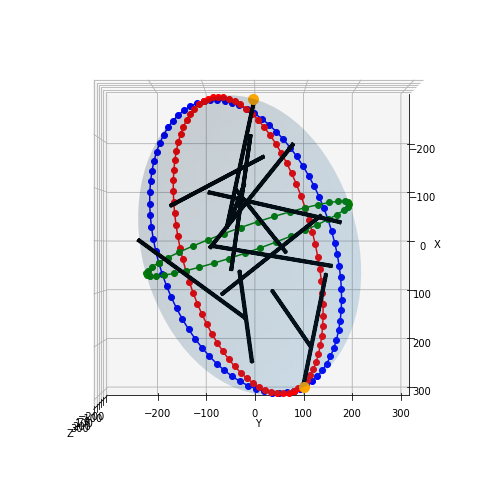

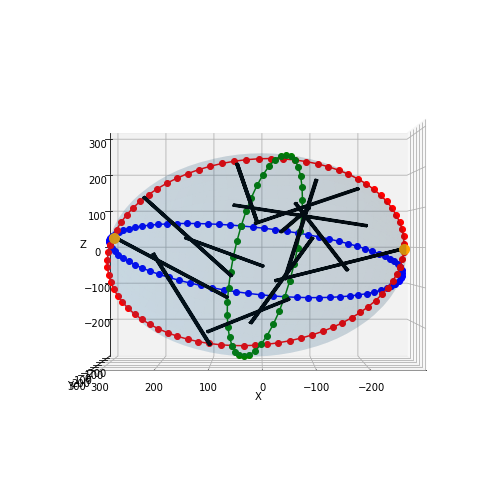

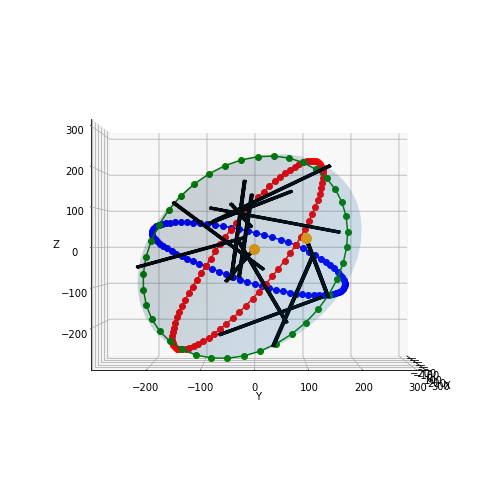

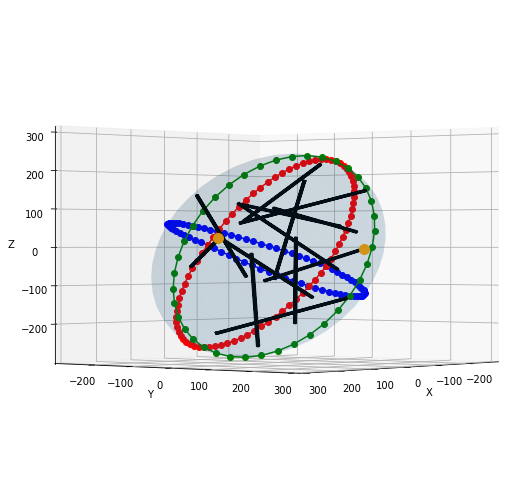

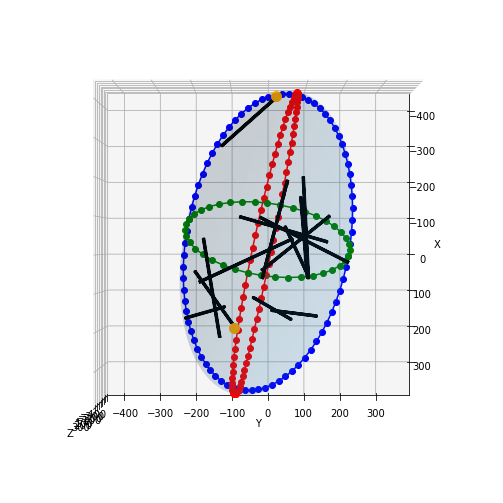

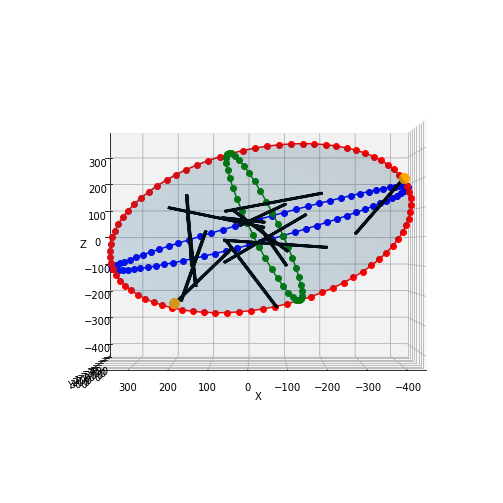

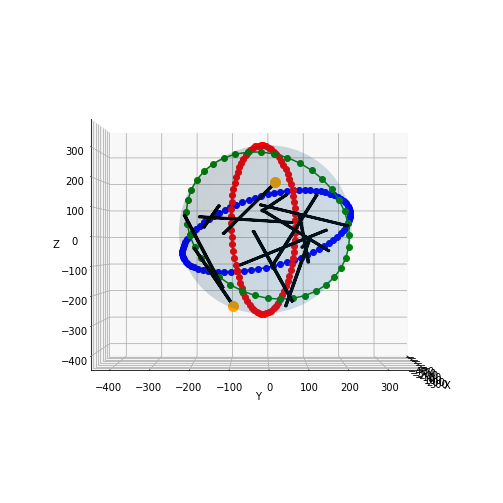

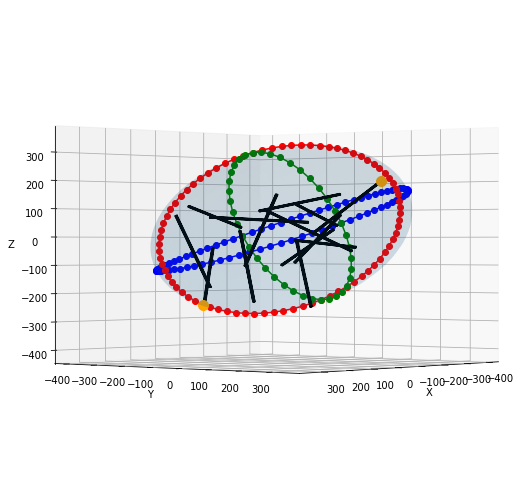

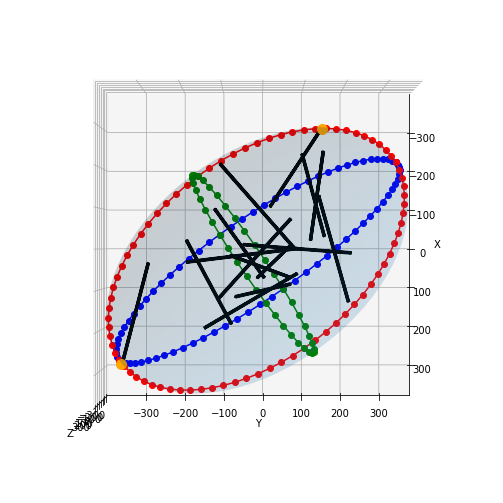

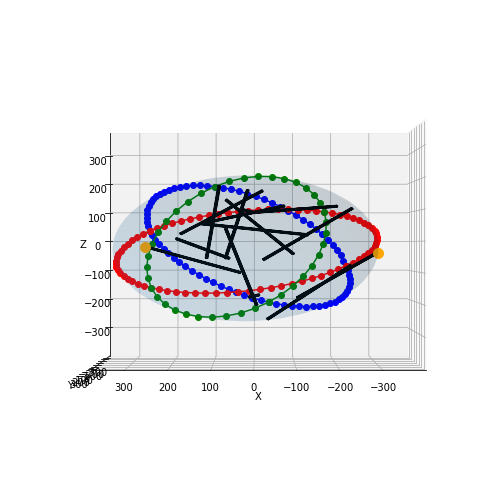

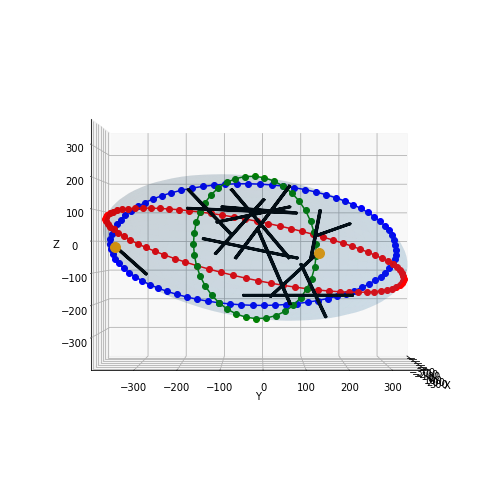

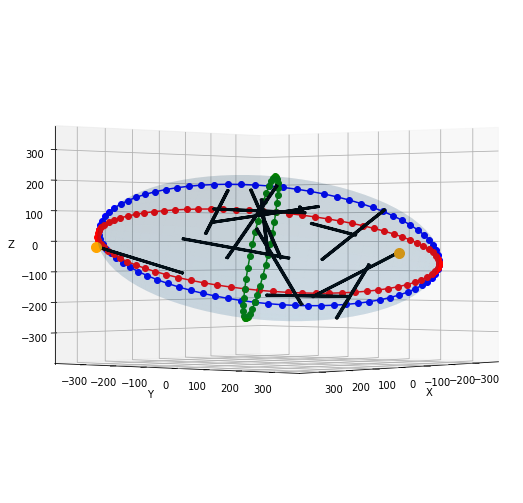

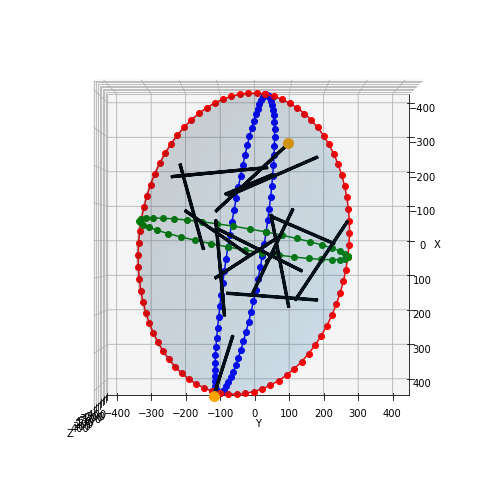

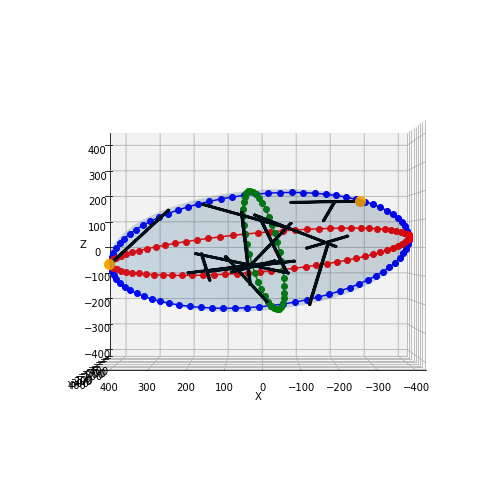

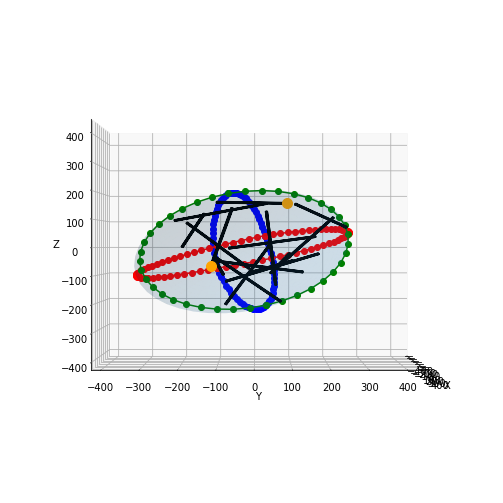

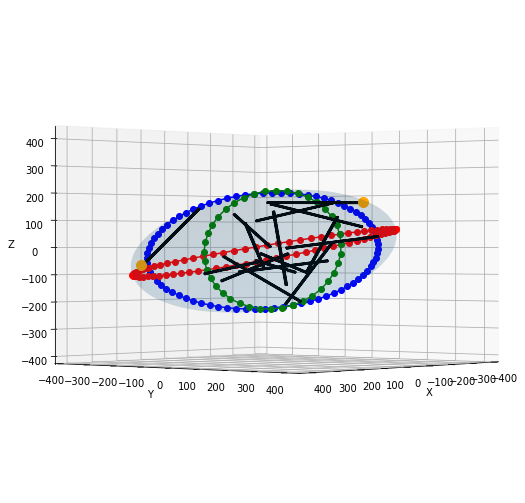

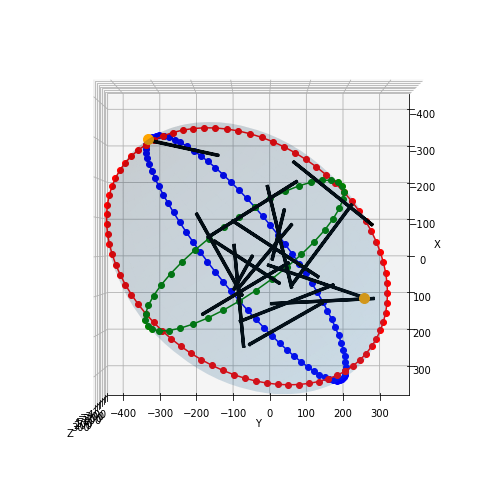

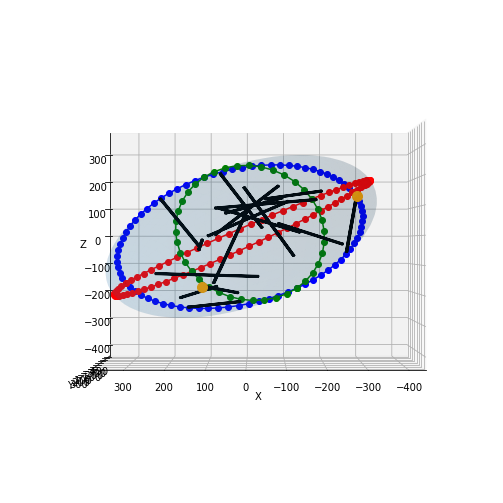

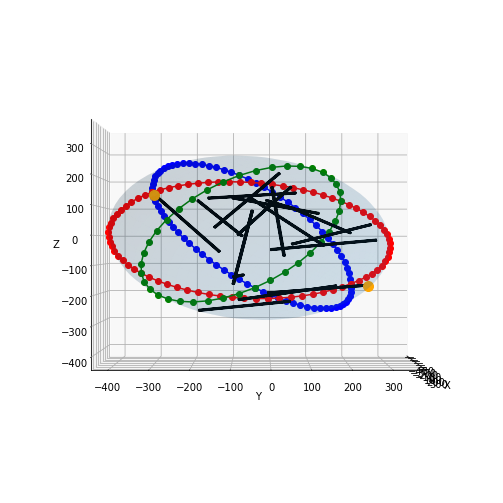

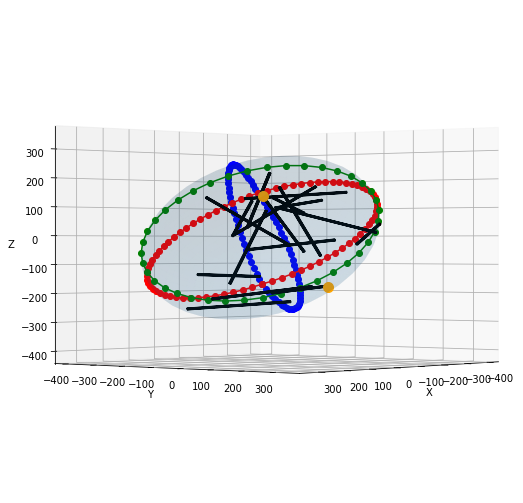

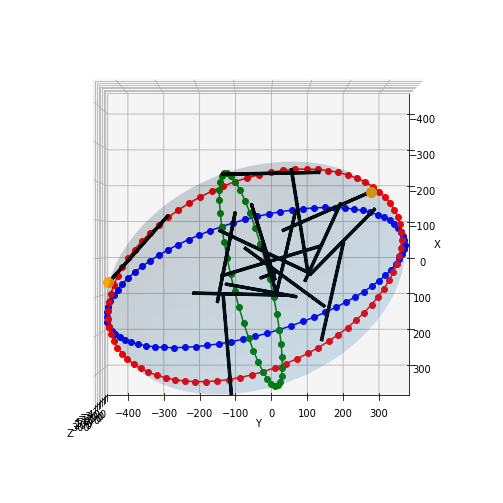

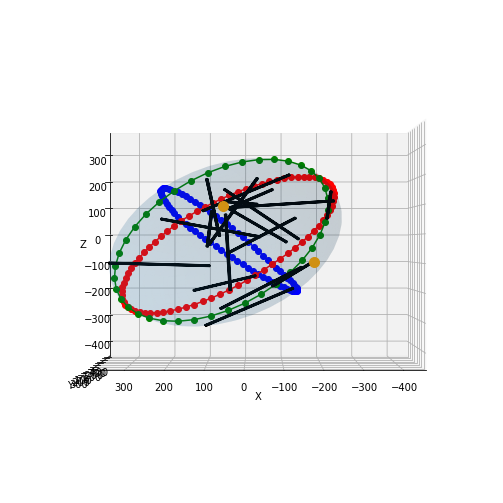

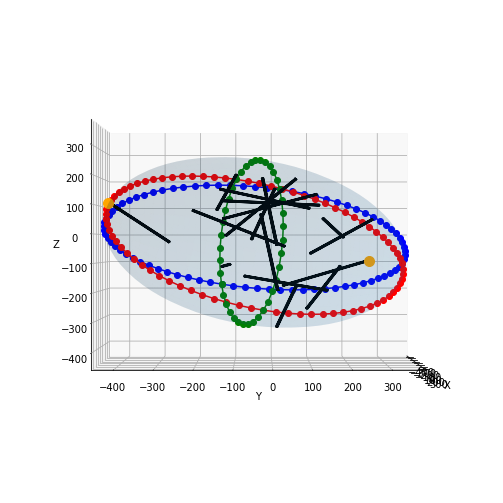

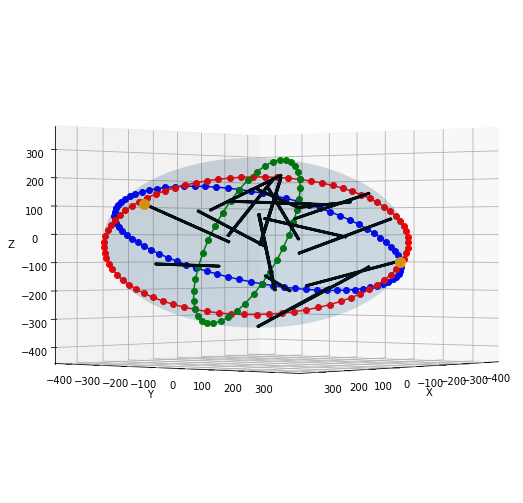

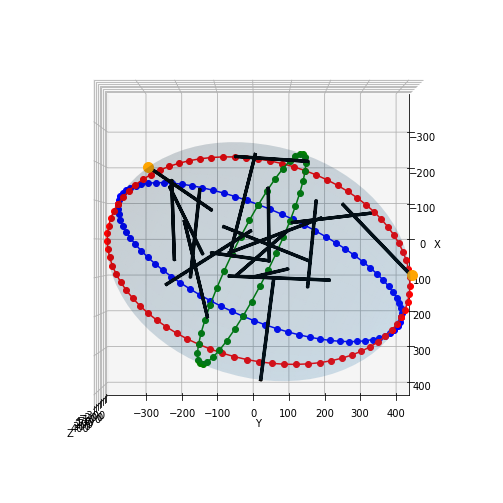

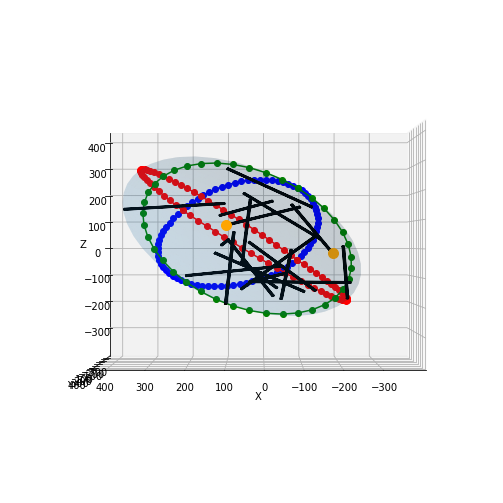

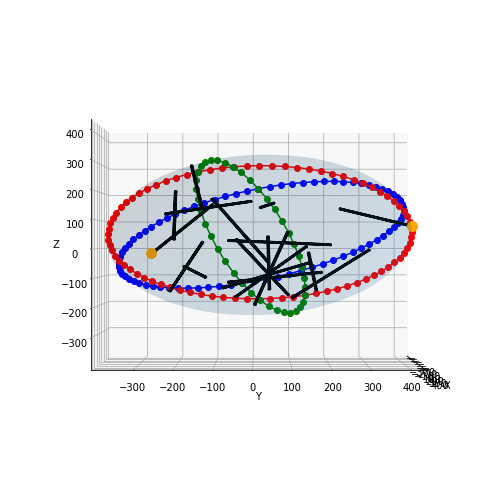

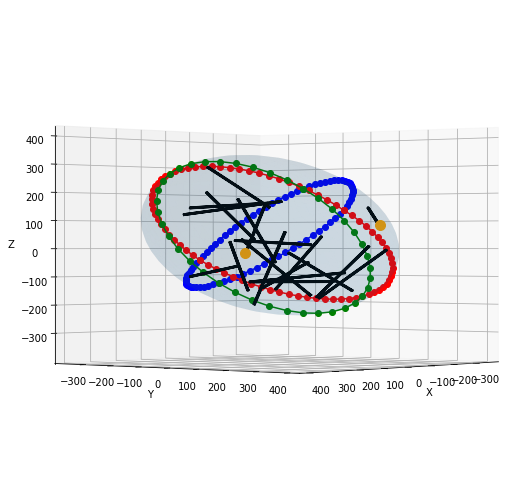

KeyboardInterrupt: 

In [10]:
if __name__ == "__main__":
    main()

In [25]:
filename = '../../instance_files/mD_vT_vars'
filehandler = open(filename, "wb")

In [26]:
!pwd

/network/rit/lab/sulialab/share/IPAS/ipas/executables/collection_no_db
